In [4]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\Administrator\OneDrive\Desktop\projects\FraudDetectionSystem\fd_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [50]:
from sklearn.metrics import recall_score


In [5]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [6]:
from joblib import load

X_train_final = load("../data/processed/X_train_final.joblib")
X_test_final  = load("../data/processed/X_test_final.joblib")
y_train       = load("../data/processed/y_train.joblib")
y_test        = load("../data/processed/y_test.joblib")

In [7]:
# Diagnostic: check for datetime/object columns that may cause dtype promotion errors
print('DTypes counts:')
print(X_train_final.dtypes.value_counts())

datetime_cols = X_train_final.select_dtypes(include=['datetime64']).columns.tolist()
print('\nDatetime columns detected:', datetime_cols)

obj_cols = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()
print('Object/Category columns detected:', obj_cols)

# If timestamp exists, drop it (it causes dtype promotion issues in sklearn)
if 'timestamp' in X_train_final.columns:
    X_train_final = X_train_final.drop(columns=['timestamp'])
    X_test_final = X_test_final.drop(columns=['timestamp'])
    print('\nDropped timestamp from train and test')

# Final check
print('\nPost-cleaning dtypes counts:')
print(X_train_final.dtypes.value_counts())

DTypes counts:
float64           42
int64              6
int32              4
datetime64[ns]     1
Name: count, dtype: int64

Datetime columns detected: ['timestamp']
Object/Category columns detected: []

Dropped timestamp from train and test

Post-cleaning dtypes counts:
float64    42
int64       6
int32       4
Name: count, dtype: int64


In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

lr.fit(X_train_final, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [9]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_lr = lr.predict(X_test_final)
y_prob_lr = lr.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0     0.9977    0.5735    0.7283     49904
           1     0.0014    0.3125    0.0028        96

    accuracy                         0.5730     50000
   macro avg     0.4996    0.4430    0.3656     50000
weighted avg     0.9958    0.5730    0.7269     50000

ROC-AUC: 0.4389486146735065


In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=500,
    class_weight='balanced',
    random_state=42
)

dt.fit(X_train_final, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=500, random_state=42)

In [11]:
y_pred_dt = dt.predict(X_test_final)
y_prob_dt = dt.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))

              precision    recall  f1-score   support

           0     0.9981    0.7408    0.8504     49904
           1     0.0019    0.2500    0.0037        96

    accuracy                         0.7399     50000
   macro avg     0.5000    0.4954    0.4270     50000
weighted avg     0.9961    0.7399    0.8488     50000

ROC-AUC: 0.5022813593766698


In [12]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Recall': [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_dt, output_dict=True)['1']['recall']
    ],
    'Precision': [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_dt, output_dict=True)['1']['precision']
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_dt)
    ]
})

results

,Model,Recall,Precision,ROC-AUC
0,Logistic Regression,0.3125,0.001407,0.438949
1,Decision Tree,0.2500,0.001852,0.502281


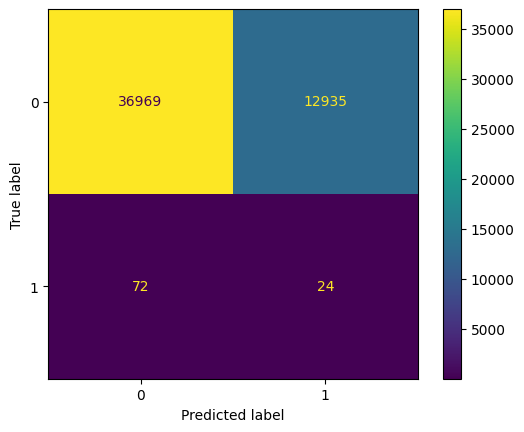

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_dt, values_format='d'
)

In [14]:
X_train_final.columns

Index(['merchant_category', 'amount (INR)', 'sender_state', 'sender_bank',
       'receiver_bank', 'hour_of_day', 'is_weekend', 'is_night',
       'is_office_hours', 'log_amount', 'is_high_amount', 'same_bank',
       'bank_pair', 'sender_age_ord', 'receiver_age_ord', 'age_gap',
       'sender_state_freq', 'transaction type_Bill Payment',
       'transaction type_P2M', 'transaction type_P2P',
       'transaction type_Recharge', 'transaction_status_FAILED',
       'transaction_status_SUCCESS', 'device_type_Android', 'device_type_Web',
       'device_type_iOS', 'network_type_3G', 'network_type_4G',
       'network_type_5G', 'network_type_WiFi', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'device_risk_High', 'device_risk_Low', 'device_risk_Medium',
       'network_risk_High', 'network_risk_Low', 'network_risk_Medium',
       'device_network_risk_High_H

In [15]:
X_train_final.head(10)

,merchant_category,amount (INR),sender_state,sender_bank,receiver_bank,hour_of_day,is_weekend,is_night,is_office_hours,log_amount,...,network_risk_Medium,device_network_risk_High_High,device_network_risk_High_Low,device_network_risk_High_Medium,device_network_risk_Low_High,device_network_risk_Low_Low,device_network_risk_Low_Medium,device_network_risk_Medium_High,device_network_risk_Medium_Low,device_network_risk_Medium_Medium
107369,0.200585,1317,0.089820,0.149770,0.100605,10,0,0,1,7.183871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
127423,0.200585,161,0.089820,0.149770,0.099945,18,0,0,1,5.087596,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
181287,0.080535,158,0.119635,0.100760,0.080320,17,0,0,1,5.068904,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
215145,0.089465,3692,0.079990,0.250395,0.249690,23,1,0,0,8.214194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
171409,0.149465,1311,0.120455,0.250395,0.249690,19,1,0,0,7.179308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40434,0.200585,1870,0.080445,0.250395,0.100375,13,0,0,1,7.534228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25862,0.149465,124,0.101255,0.149770,0.098665,20,0,0,0,4.828314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
136691,0.119435,1148,0.089820,0.118860,0.100375,17,0,0,1,7.046647,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
120842,0.100010,782,0.080445,0.149770,0.100605,16,1,0,1,6.663133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
123454,0.080535,83,0.079710,0.149770,0.100605,23,0,0,0,4.430817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=200,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train_final, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=200, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [17]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf = rf.predict(X_test_final)
y_prob_rf = rf.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0     0.9981    0.9990    0.9986     49904
           1     0.0000    0.0000    0.0000        96

    accuracy                         0.9971     50000
   macro avg     0.4990    0.4995    0.4993     50000
weighted avg     0.9962    0.9971    0.9966     50000

ROC-AUC: 0.5051926782756225


In [18]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight


519.8333333333334

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train_final, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [20]:
y_pred_xgb = xgb.predict(X_test_final)
y_prob_xgb = xgb.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


              precision    recall  f1-score   support

           0     0.9981    0.9814    0.9897     49904
           1     0.0032    0.0312    0.0058        96

    accuracy                         0.9796     50000
   macro avg     0.5007    0.5063    0.4978     50000
weighted avg     0.9962    0.9796    0.9878     50000

ROC-AUC: 0.4561823284038688


In [21]:
feature_names = X_train_final.columns

In [33]:
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': feature_names,  # must match encoded column order
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(52)



,feature,importance
42,network_risk_Medium,0.029702
40,network_risk_High,0.025720
41,network_risk_Low,0.025047
22,transaction_status_SUCCESS,0.024594
9,log_amount,0.023640
30,day_of_week_Friday,0.022905
43,device_network_risk_High_High,0.021924
7,is_night,0.021709
31,day_of_week_Monday,0.021341
1,amount (INR),0.021126


In [32]:
len(X_train_final.columns)

52

In [40]:
feature_to_remove = 'device_network_risk_High_Medium'

idx = feature_names.get_loc(feature_to_remove)

In [41]:
idx = list(feature_names).index(feature_to_remove)


In [42]:
X_train_final = np.delete(X_train_final, idx, axis=1)
X_test_final  = np.delete(X_test_final, idx, axis=1)


In [43]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, y_prob_xgb
)

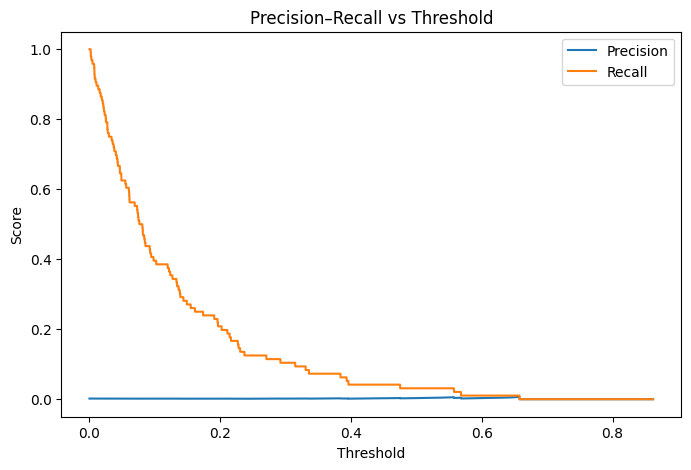

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs Threshold')
plt.legend()
plt.show()

In [45]:
import numpy as np
from sklearn.metrics import classification_report

thresholds_to_test = [0.01, 0.02, 0.05, 0.1, 0.2]

results = []

for t in thresholds_to_test:
    y_pred_t = (y_prob_xgb >= t).astype(int)

    report = classification_report(
        y_test, y_pred_t, output_dict=True, zero_division=0
    )

    results.append({
        'threshold': t,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': report['1']['f1-score']
    })

import pandas as pd
pd.DataFrame(results)

,threshold,recall,precision,f1
0,0.01,0.906250,0.001836,0.003665
1,0.02,0.854167,0.001858,0.003707
2,0.05,0.625000,0.001706,0.003403
3,0.10,0.395833,0.001568,0.003124
4,0.20,0.208333,0.001720,0.003412


In [46]:
chosen_threshold = 0.02

In [47]:
y_pred_final = (y_prob_xgb >= chosen_threshold).astype(int)

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred_final, digits=4))
confusion_matrix(y_test, y_pred_final)

              precision    recall  f1-score   support

           0     0.9976    0.1171    0.2096     49904
           1     0.0019    0.8542    0.0037        96

    accuracy                         0.1185     50000
   macro avg     0.4997    0.4856    0.1067     50000
weighted avg     0.9957    0.1185    0.2092     50000



array([[ 5844, 44060],
       [   14,    82]], dtype=int64)

In [51]:
fraud_capture_rate = recall_score(y_test, y_pred_final)
fraud_capture_rate

0.8541666666666666

In [52]:
alert_rate = y_pred_final.mean()
alert_rate

0.88284

In [56]:
from joblib import dump

dump(xgb, "../models/fraud_xgb_model.joblib")

dump(chosen_threshold, "../models/fraud_threshold.joblib")

dump(feature_names, "../models/feature_names.joblib")

['../models/feature_names.joblib']